### This notebook predicts the price in two parts.
1. Step 1: Predicting whether price will go up or down
2. Step 2: Using output of step 1 as an input, we predict the magnitude of price

## Step 1:

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import ta  # Technical Analysis library
import pickle

In [2]:
# Load the direction model predictions
with open('Direction_LSTM.pkl', 'rb') as file:
    direction_model = pickle.load(file)

# Load the data
data = pd.read_csv('EURUSD_data')

In [3]:
# Feature Engineering
# Calculate Technical Indicators
data['SMA'] = data['Close'].rolling(window=14).mean()
data['EMA'] = data['Close'].ewm(span=14, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['MACD'] = ta.trend.MACD(data['Close']).macd()
data['Bollinger_Upper'] = ta.volatility.BollingerBands(data['Close']).bollinger_hband()
data['Bollinger_Lower'] = ta.volatility.BollingerBands(data['Close']).bollinger_lband()

# Create Lagged Features
for lag in range(1, 4):
    data[f'Lag_{lag}'] = data['Close'].shift(lag)

# Drop rows with NaN values
data.dropna(inplace=True)

# Prepare features for direction prediction
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 
                 'Bollinger_Upper', 'Bollinger_Lower', 'Lag_1', 'Lag_2', 'Lag_3']]

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [4]:
# Reshape for LSTM direction prediction
scaled_features_lstm = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))

# Predict the direction using the saved model
predicted_direction = (direction_model.predict(scaled_features_lstm) > 0.5).astype(int)

# Add predicted direction as a feature
data['Predicted_Direction'] = predicted_direction
print(predicted_direction)

81/81 [==============================] - 0s 588us/step
[[0]
 [1]
 [0]
 ...
 [1]
 [0]
 [0]]


## Step 2:

In [5]:

# Prepare features for price prediction, including the predicted direction
price_features = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Predicted_Direction']]
target = data['Close']

# Scale the data for price prediction
scaled_data = scaler.fit_transform(price_features)

# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Use the 'Close' price as the target
    return np.array(X), np.array(y)

seq_length = 60  # Using 60 days of data to predict the next day's price
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
# Initialize the LSTM model for price prediction
model = Sequential()

# LSTM layer 1
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# LSTM layer 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           42800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 73051 (285.36 KB)
Trainable params: 73051 (285.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
63/63 [==============================] - 4s 37ms/step - loss: 0.0140 - val_loss: 8.4090e-04
Epoch 2/50
63/63 [==============================] - 2s 30ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/50
63/63 [==============================] - 2s 29ms/step - loss: 0.0024 - val_loss: 7.5727e-04
Epoch 4/50
63/63 [==============================] - 2s 29ms/step - loss: 0.0023 - val_loss: 8.6760e-04
Epoch 5/50
63/63 [==============================] - 2s 30ms/step - loss: 0.0022 - val_loss: 7.9665e-04
Epoch 6/50
63/63 [==============================] - 2s 29ms/step - loss: 0.0020 - val_loss: 6.8278e-04
Epoch 7/50
63/63 [==============================] - 2s 30ms/step - loss: 0.0019 - val_loss: 9.1097e-04
Epoch 8/50
63/63 [==============================] - 2s 29ms/step - loss: 0.0019 - val_loss: 7.2312e-04
Epoch 9/50
63/63 [==============================] - 2s 30ms/step - loss: 0.0017 - val_loss: 6.5643e-04
Epoch 10/50
63/63 [==============================] - 2s 31ms/step - loss: 0.0

In [8]:
# Saving the model

import pickle

# Assume 'model' is your trained LSTM model
model_filename = 'Magnitude_LSTM.pkl'

# Save the model
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved as {model_filename}")

Model saved as Magnitude_LSTM.pkl


In [9]:
# Predicting on test data
predicted_prices = model.predict(X_test)

# Inverse transform the predicted and actual values to get them in the original scale
predicted_prices = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], predicted_prices], axis=1))[:, -1]
actual_prices = scaler.inverse_transform(np.concatenate([X_test[:, -1, :-1], y_test.reshape(-1, 1)], axis=1))[:, -1]

16/16 [==============================] - 1s 9ms/step


In [10]:
from sklearn.metrics import r2_score

# Evaluate the model
mse = np.mean((predicted_prices - actual_prices) ** 2)
print(f"Mean Squared Error: {mse}")

r_squared = r2_score(actual_prices, predicted_prices)
print(f"R-squared: {r_squared}")

Mean Squared Error: 0.0002510788223380078
R-squared: 0.9680739532801764


In [11]:
import statsmodels.api as sm

# Adding a constant to the predicted prices to represent the intercept
X = sm.add_constant(predicted_prices)

# Fit the model (y = actual_prices)
ols_model = sm.OLS(actual_prices, X).fit()

# Get the p-values
p_values = ols_model.pvalues
print(f"P-value of the model: {p_values[1]}")

print(ols_model.summary())

P-value of the model: 0.0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 2.104e+04
Date:                Tue, 27 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:43:15   Log-Likelihood:                 1453.2
No. Observations:                 504   AIC:                            -2902.
Df Residuals:                     502   BIC:                            -2894.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0248     

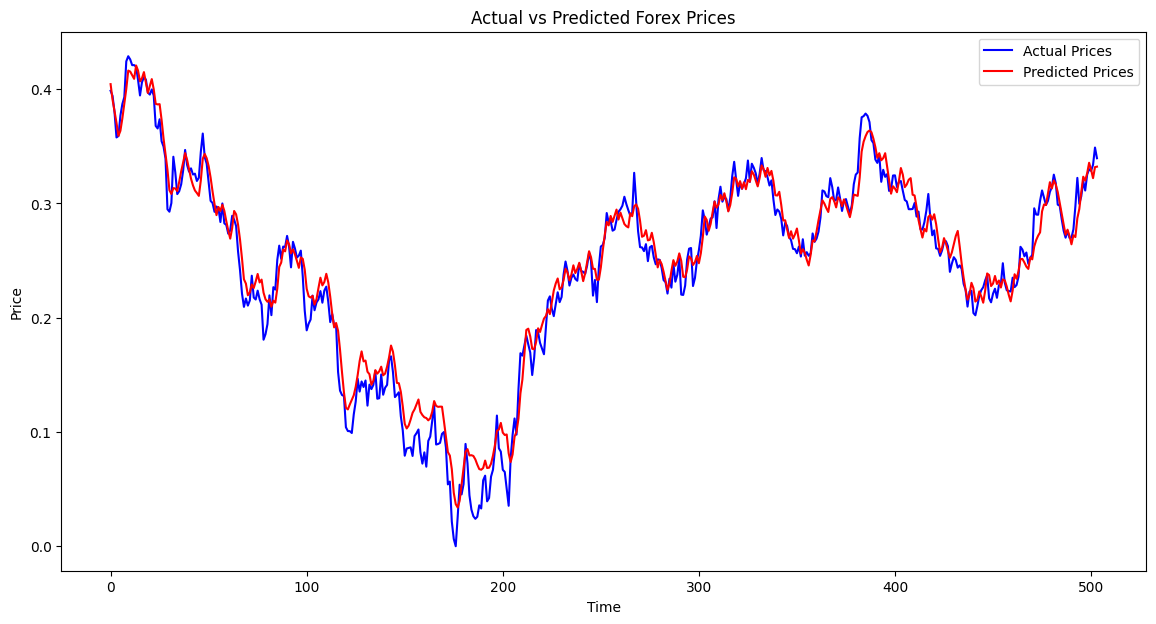

In [12]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title('Actual vs Predicted Forex Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()